# 1.데이터 로드

구매한 고객에 대한 코호트 분석

In [1]:
import pandas as pd
import warnings

#경고 무시
warnings.filterwarnings('ignore')

session = pd.read_csv("data/Session.csv")
product = pd.read_csv("data/Product.csv")

data = pd.merge(product,session, how ='left', on = ['CLNT_ID','SESS_ID'])

print(len(data))
data.head(3)

5024906


,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM
0,4139680,7605037,12,642112,색상:워터멜론,[바비브라운],"39,000",1,1,20180526,21.0,902,desktop,Seoul,Seoul
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,"39,000",2,172,20180413,18.0,113,mobile,Gyeonggi-do,Icheon-si
2,4142395,6158159,85,179538,(not set),[아베다],"39,000",1,1,20180619,107.0,"6,524",desktop,Seoul,Seoul


# 2.데이터 정제

In [2]:
#날짜 정제
data['SESS_DT'] = pd.to_datetime(data['SESS_DT'], format = "%Y%m%d")

#필요 컬럼 선택
data = data[['CLNT_ID','SESS_ID','SESS_DT','PD_C','PD_ADD_NM','PD_BRA_NM','PD_BUY_AM']].sort_values(['CLNT_ID','SESS_DT'])

data.sample(3)

,CLNT_ID,SESS_ID,SESS_DT,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM
3186741,2743696,3158405,2018-08-08,804371,제품선택:E2-401.플로랄와인 20매X2 / 1개,요요쉬,"16,000"
666971,2550284,4315966,2018-07-19,182944,색상:베이지|사이즈:90 / 1개,티비제이,"5,000"
3125993,4515339,6439942,2018-06-14,476827,색상:아이보리(IV)/사이즈:66,[미니멈],"192,600"


# 3.고객 유지율 표

월별 고객이 얼마나 유지되었나 **코호트 분석**을 해보자

In [3]:
# 연-월 날짜
data['OrderPeriod'] = data['SESS_DT'].apply(lambda x: x.strftime('%Y-%m'))

# 첫 주문 날짜
data.set_index('CLNT_ID',inplace = True)

data['CohortGroup'] = data.groupby(level=0)['SESS_DT'].min().apply(lambda x: x.strftime('%Y-%m'))
data.reset_index(inplace = True)

data.head(10)

,CLNT_ID,SESS_ID,SESS_DT,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,OrderPeriod,CohortGroup
0,8,7017688,2018-06-05,206218,색상:BLACK|사이즈:ONE SIZE / 1개,플라넷비,"38,000",2018-06,2018-06
1,8,6964877,2018-06-06,206218,색상:BLACK|사이즈:ONE SIZE / 1개,플라넷비,"38,000",2018-06,2018-06
2,14,1156991,2018-09-11,645262,색상:LL1G14817AIN|사이즈:FREE / 1개,로이드(주얼리),"29,900",2018-09,2018-09
3,14,1156991,2018-09-11,369141,색상:LL2G16216RGB|사이즈:FREE / 1개,로이드,"39,900",2018-09,2018-09
4,25,9506206,2018-04-25,715121,(not set),[이롬],"92,000",2018-04,2018-04
5,25,8113243,2018-05-18,715121,(not set),[이롬],"92,000",2018-05,2018-04
6,25,6059256,2018-06-21,715072,(not set),[이롬],"47,000",2018-06,2018-04
7,25,5317297,2018-07-03,598634,피테로마 때박살:피테로마 때박살 120종,[유씨지],"39,800",2018-07,2018-04
8,32,1136737,2018-09-11,48881,색상:선택01_DNV|사이즈:105(XL) / 1개,엠폴햄,"13,500",2018-09,2018-09
9,32,1136737,2018-09-11,48881,색상:선택01_SBL|사이즈:105(XL) / 1개,엠폴햄,"13,500",2018-09,2018-09


In [4]:
import numpy as np

grouped = data.groupby(['CohortGroup','OrderPeriod'])

cohorts = grouped.agg({'CLNT_ID':pd.Series.nunique,
                       'SESS_ID':pd.Series.nunique})

cohorts.rename(columns={'CLNT_ID':'TotalUsers',
                        'SESS_ID':'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders
CohortGroup OrderPeriod                         
2018-04     2018-04          267019       426747
            2018-05          103120       236551
            2018-06           85602       206470
            2018-07           76196       181472
            2018-08           61891       136295

- TotalOrders은 총 주문건수(한 사람이 여러번 사는 경우 포함)
- 2018년 4월에 첫구매한 고객 중 5월에도 구매한 고객은 103120명
- 달이 지날수록 유지되는 고객은 감소함
    - 재방문율이 감소하고 있음

코호트 쉽게 이해하고 시각화하기 위한 CohortPeriod 변수 생성

In [5]:
def cohort_period(data):
    data['CohortPeriod'] = np.arange(len(data))+1
    return data

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  CohortPeriod
CohortGroup OrderPeriod                                       
2018-04     2018-04          267019       426747             1
            2018-05          103120       236551             2
            2018-06           85602       206470             3
            2018-07           76196       181472             4
            2018-08           61891       136295             5

테이블 정리

In [6]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-04    267019
2018-05    177882
2018-06    139987
2018-07    116848
2018-08     93007
Name: TotalUsers, dtype: int64

- 매달 신규 구매자와 이용자를 합친 값임에도 불구하고 수치가 감소하고 있음.

In [7]:
cohorts['TotalUsers'].unstack(0)

CohortGroup,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
CohortPeriod,,,,,,
1,267019.0,177882.0,139987.0,116848.0,93007.0,127994.0
2,103120.0,49400.0,36026.0,25608.0,19837.0,NaN
3,85602.0,37472.0,23290.0,10196.0,NaN,NaN
4,76196.0,28629.0,10426.0,NaN,NaN,NaN
5,61891.0,12464.0,NaN,NaN,NaN,NaN
6,19497.0,NaN,NaN,NaN,NaN,NaN


- 9월에 127884명으로 다시 증가함
- 여름 시즌에 감소하는 것으로 추정

비율로 환산

In [8]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
CohortPeriod,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.386190,0.277712,0.257352,0.219157,0.213285,NaN
3,0.320584,0.210657,0.166373,0.087259,NaN,NaN
4,0.285358,0.160944,0.074478,NaN,NaN,NaN
5,0.231785,0.070069,NaN,NaN,NaN,NaN
6,0.073017,NaN,NaN,NaN,NaN,NaN


# 4.시각화

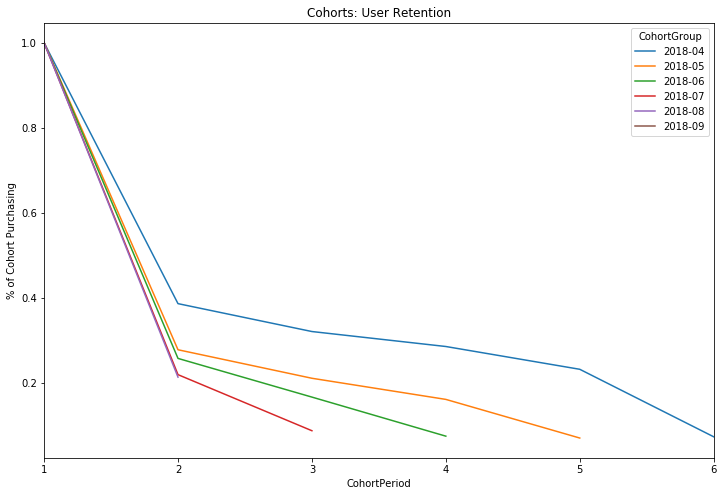

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

user_retention[['2018-04', '2018-05', '2018-06','2018-07','2018-08','2018-09']].plot(figsize=(12,8))
plt.title('Cohorts: User Retention')
plt.xlim(1, 6)
plt.ylabel('% of Cohort Purchasing');

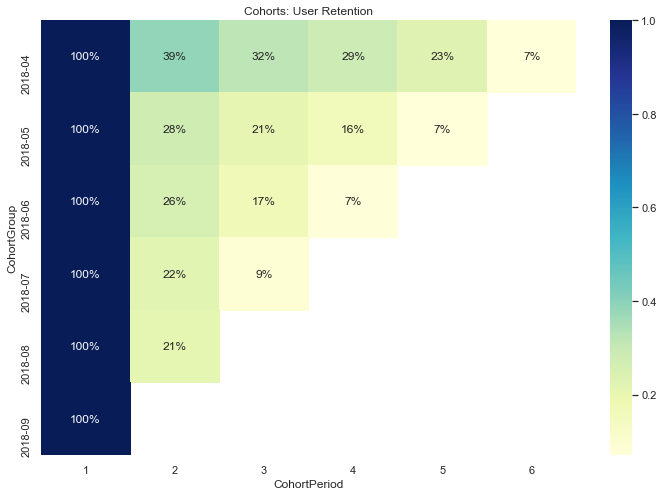

In [10]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', cmap="YlGnBu");

- 첫번째 달 전환율이 많으면 39%이고 적으면 21%으로 비교적 높은 수치라 생각함
- 월별 분석이기 때문에 자세한 분석이 어려움
- 일별/주별 혹은 카테고리별 분석을 진행해볼 필요가 있음

코호트분석은 **가로로 비율**이 어떻게 변화했나, **대각선 비율(같은 날짜)** 을 살펴본다